In [62]:
pip install git+https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git to /tmp/pip-req-build-bu8lf_88
  Running command git clone --filter=blob:none --quiet https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git /tmp/pip-req-build-bu8lf_88
  Resolved https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git to commit bdbddee93a6d59029989c32cc41748adb2724f51
  Preparing metadata (setup.py) ... done


## Initiate the environment

In [63]:
%matplotlib inline
import numpy as np
#from scipy.stats import sem
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from numpy.random import randn
from scipy import array, newaxis
from IPython.display import clear_output
import os, sys
import gymnasium as gym
import time
import text_flappy_bird_gym
from tqdm import tqdm
import pickle
from collections import defaultdict
from mpl_toolkits.mplot3d import axes3d
import pandas as pd
from tqdm import tqdm


In [64]:
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
obs = env.reset()

In [65]:
class Agent:
    """
    The Base class that is implemented by
    other classes to avoid the duplicate 'act'
    method
    """
    
    ## take random action if random float is less than epsilon
    ## otherwise select action with highest Q-score for the given state
        
    def act(self, state): #epsilon-greedy policy
        
        
        if np.random.uniform(0, 1) < self.eps:
            action = env.action_space.sample()
            return action
        else:
            action = np.argmax(q[state])
            return action

In [66]:
class Q_Agent(Agent):
    """
    The Q-Learning Agent Class
    
    """        
    
    def __init__(self, eps, step_size, discount):
        self.eps = eps
        self.step_size = step_size
        self.discount = discount
        
    def update(self):
        old_value = q[state][action]
        next_max = np.max(q[next_state])
        
        new_value = (1 - self.step_size) * old_value + self.step_size * (reward +  self.discount * next_max)
        q[state][action] = new_value

class SarsaAgent(Agent):
    """
    The SARSA Agent Class
    
    """    
    
    def __init__(self, eps, step_size, discount):
        self.eps = eps
        self.step_size = step_size
        self.discount = discount
        
    def update(self):    
        q[state][action]+= self.step_size * (reward + self.discount * (q[next_state][next_action]) - q[state][action])

class RandomAgent():
    """
    The Random Agent Class
    
    """
    def __init__(self, eps, step_size, discount):
        self.eps = eps
        self.eps=1
        self.step_size = step_size
        self.discount = discount
        
        
    def act(self, state): 
        
            action = env.action_space.sample()
            return action

    def update(self):
            pass

In [67]:
agents = {
            "Q-learning": Q_Agent,
            "Sarsa": SarsaAgent,
            "RandomAgent": RandomAgent
    }

In [68]:
all_the_q_tables = {}
all_reward_sums = {} # Contains sum of rewards during episode

for algorithm in ["Q-learning", "Sarsa", "RandomAgent"]:
    
    q = defaultdict(lambda: np.zeros(2))  # The dict of action-value estimates.
    all_reward_sums[algorithm] = []
    current_agent = agents[algorithm](eps=0.2, step_size = 0.7, discount=0.95)
    total_epochs = 0
    for i in tqdm(range(1000)):
      state = env.reset()
      state = state[0]
      done = False
      total_reward = 0

      while not done:
                  
        action = current_agent.act(state)
        next_state, reward, done, _, info = env.step(action)
        #For SARSA acquiring the on-policy next action
        next_action = current_agent.act(next_state)
        if done == True:
            reward = -1
        
        # Update total reward 
        total_reward += reward
        #Update q values table
        current_agent.update()      
        state = next_state
        if done:
          break
      all_reward_sums[algorithm].append(total_reward)
      env.close()
    all_the_q_tables[algorithm] = q

100%|██████████| 1000/1000 [00:00<00:00, 4011.93it/s]


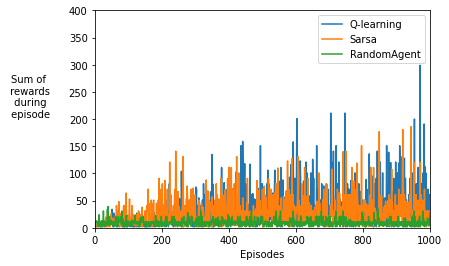

In [69]:
for algorithm in ["Q-learning", "Sarsa", "RandomAgent" ]:
    plt.plot(all_reward_sums[algorithm], label=algorithm)
plt.xlabel("Episodes")
plt.ylabel("Sum of\n rewards\n during\n episode",rotation=0, labelpad=40)
plt.xlim(0,1000)
plt.ylim(0,400)
plt.legend()
plt.show()

#Hyper-Parameter Tuning

In [70]:
df = pd.DataFrame({'Algorithm': pd.Series(dtype='str'),
                    'Epsilon': pd.Series(dtype='float'),
                    'Step-Size': pd.Series(dtype='float'),
                    'Discount': pd.Series(dtype='float'),
                    'Mean-Reward': pd.Series(dtype='float')})

EPS = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
STEP_SIZE = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
DISCOUNT = [1.0, 0.95, 0.9, 0.85, 0.8, 0.75]

Algorithms = []
Epsilons = []
Step_Sizes = []
Discounts = []
Means = []


In [71]:
for eps in EPS:
  for step_size in STEP_SIZE:
    for disc in DISCOUNT:

      all_the_q_tables = {}
      all_reward_sums = {} 

      for algorithm in ["Q-learning", "Sarsa", "RandomAgent"]:
          
          q = defaultdict(lambda: np.zeros(2))  # The dict of action-value estimates.
          all_reward_sums[algorithm] = []
          current_agent = agents[algorithm](eps=eps, step_size = step_size, discount=disc)
          total_epochs = 0
          for i in range(1000):
            state = env.reset()
            state = state[0]
            done = False
            total_reward = 0

            while not done:
                        
              action = current_agent.act(state)
              next_state, reward, done, _, info = env.step(action)
              #For SARSA acquiring the on-policy next action
              next_action = current_agent.act(next_state)
              if done == True:
                  reward = -1
              
              # Update total reward 
              total_reward += reward
              #Update q values table
              current_agent.update()      
              state = next_state
              if done:
                break
            all_reward_sums[algorithm].append(total_reward)
            env.close()
          all_the_q_tables[algorithm] = q

          Algorithms.append(algorithm)
          Epsilons.append(eps)
          Step_Sizes.append(step_size)
          Discounts.append(disc)
          Means.append(np.array(all_reward_sums[algorithm]).mean())
          print(f' Algorithm: {algorithm}; Epsilon: {eps}; Step Size: {step_size}; Discount: {disc}; Mean Reward: {np.array(all_reward_sums[algorithm]).mean()} ')


 Algorithm: Q-learning; Epsilon: 0.05; Step Size: 0.4; Discount: 1.0; Mean Reward: 23.016 
 Algorithm: Sarsa; Epsilon: 0.05; Step Size: 0.4; Discount: 1.0; Mean Reward: 30.594 
 Algorithm: RandomAgent; Epsilon: 0.05; Step Size: 0.4; Discount: 1.0; Mean Reward: 9.482 
 Algorithm: Q-learning; Epsilon: 0.05; Step Size: 0.4; Discount: 0.95; Mean Reward: 24.014 
 Algorithm: Sarsa; Epsilon: 0.05; Step Size: 0.4; Discount: 0.95; Mean Reward: 27.007 
 Algorithm: RandomAgent; Epsilon: 0.05; Step Size: 0.4; Discount: 0.95; Mean Reward: 9.375 
 Algorithm: Q-learning; Epsilon: 0.05; Step Size: 0.4; Discount: 0.9; Mean Reward: 20.102 
 Algorithm: Sarsa; Epsilon: 0.05; Step Size: 0.4; Discount: 0.9; Mean Reward: 14.662 
 Algorithm: RandomAgent; Epsilon: 0.05; Step Size: 0.4; Discount: 0.9; Mean Reward: 9.455 
 Algorithm: Q-learning; Epsilon: 0.05; Step Size: 0.4; Discount: 0.85; Mean Reward: 21.436 
 Algorithm: Sarsa; Epsilon: 0.05; Step Size: 0.4; Discount: 0.85; Mean Reward: 24.125 
 Algorithm: Ra

In [72]:
df['Algorithm'] = Algorithms
df['Epsilon'] = Epsilons
df['Step-Size'] = Step_Sizes
df['Discount'] = Discounts
df['Mean-Reward'] = Means

In [73]:
for algo in ["Q-learning", "Sarsa", "RandomAgent"]:
  temp = df[df['Algorithm']==algo]
  max = np.max(temp['Mean-Reward'])
  row = temp[temp['Mean-Reward'] == max]
  row = row.iloc[0]

  print(f"Best parameters for {algo} are: ")
  print(f"Epsilon: {row['Epsilon']}")
  print(f"Step_Size: {row['Step-Size']}")
  print(f"Discount: {row['Discount']}")
  print('************************************')

Best parameters for Q-learning are: 
Epsilon: 0.05
Step_Size: 0.8
Discount: 0.75
************************************
Best parameters for Sarsa are: 
Epsilon: 0.05
Step_Size: 0.6
Discount: 0.75
************************************
Best parameters for RandomAgent are: 
Epsilon: 0.3
Step_Size: 0.8
Discount: 0.85
************************************


#Final Run For 10000 Iterations

In [74]:
all_the_q_tables = {}
all_reward_sums = {} # Contains sum of rewards during episode

for algorithm in ["Q-learning", "Sarsa", "RandomAgent"]:
    temp = df[df['Algorithm']==algo]
    max = np.max(temp['Mean-Reward'])
    row = temp[temp['Mean-Reward'] == max]
    row = row.iloc[0]
    eps, step_size, discount = row['Epsilon'], row['Step-Size'], row['Discount']
    
    q = defaultdict(lambda: np.zeros(2))  # The dict of action-value estimates.
    all_reward_sums[algorithm] = []
    current_agent = agents[algorithm](eps=eps, step_size = step_size, discount=discount)
    total_epochs = 0
    for i in tqdm(range(10000)):
      state = env.reset()
      state = state[0]
      done = False
      total_reward = 0

      while not done:
                  
        action = current_agent.act(state)
        next_state, reward, done, _, info = env.step(action)
        #For SARSA acquiring the on-policy next action
        next_action = current_agent.act(next_state)
        if done == True:
            reward = -1
        
        # Update total reward 
        total_reward += reward
        #Update q values table
        current_agent.update()      
        state = next_state
        if done:
          break
      all_reward_sums[algorithm].append(total_reward)
      env.close()
    all_the_q_tables[algorithm] = q

100%|██████████| 10000/10000 [00:02<00:00, 4581.82it/s]


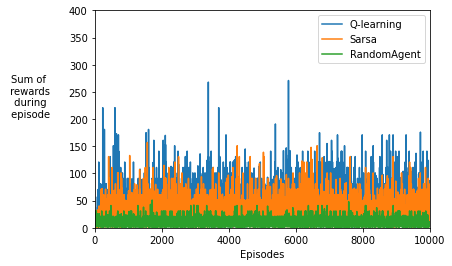

In [75]:
for algorithm in ["Q-learning", "Sarsa", "RandomAgent" ]:
    plt.plot(all_reward_sums[algorithm], label=algorithm)
plt.xlabel("Episodes")
plt.ylabel("Sum of\n rewards\n during\n episode",rotation=0, labelpad=40)
plt.xlim(0,10000)
plt.ylim(0,400)
plt.legend()
plt.show()

#State-Value Function

<ipython-input-76-144eb76db65b>:11: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


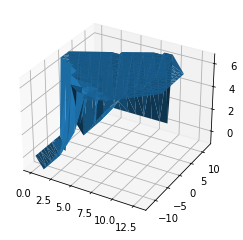

In [76]:
q_policy = dict((k,np.max(v)) for k, v in all_the_q_tables['Q-learning'].items())
x_list = []
y_list = []
z_list = []
for key in q_policy.keys():
    x_list.append(key[0])
    y_list.append(key[1])
for value in q_policy.values():
    z_list.append(value)
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(x_list, y_list, z_list)
plt.show()